## Transfer Learning в задаче бинарной классификации рентгеновских снимков
Целью является создание модели грубокого машинного обучения, способной с высокой степенью точности (accuracy) определять наличие и отсутствие пнемонии по рентгеновским снимкам грудной клетки. </br>
В процессе исследования будет проведенен процесс предподготовки данных с применением аугментации, оценен вклад метода переноса обучения для данной задачи по классификации, будут определены гиперпараметры, позволяющие добиться высокой accuracy на тестовом датасете для каждой использованной предобученной модели.

In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random
import seaborn as sns
import torch,torchvision
from  matplotlib import pyplot as plt
from PIL import Image 
from tqdm import tqdm
%matplotlib inline

In [2]:
# Для воспроизводимости результатов зафиксируем сиды:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

### Стадия предварительной обработки данных

In [3]:
pwd = os.getcwd()
list_folders = os.listdir('chest_xray')
print('Текущее расположение репозитория', pwd)
print('Список папок', list_folders)

Текущее расположение репозитория D:\Python_notebooks\repository_Koldim2001\transfer_learning_CNN
Список папок ['test', 'train', 'val']


Определим число изображений в каждой из папок:

In [4]:
img_test_normal = os.listdir('chest_xray/test/NORMAL')
img_test_pathology = os.listdir('chest_xray/test/PNEUMONIA')
img_train_normal = os.listdir('chest_xray/train/NORMAL')
img_train_pathology = os.listdir('chest_xray/train/PNEUMONIA')
img_val_normal = os.listdir('chest_xray/val/NORMAL')
img_val_pathology = os.listdir('chest_xray/val/PNEUMONIA')

In [5]:
print('Суммарно изображений в тестовом датасете:',
      len(img_test_normal)+len(img_test_pathology))
print('Суммарно изображений в трейновом датасете:',
      len(img_train_normal)+len(img_train_pathology))
print('Суммарно изображений в валидационном датасете:',
      len(img_val_normal)+len(img_val_pathology))

Суммарно изображений в тестовом датасете: 624
Суммарно изображений в трейновом датасете: 5216
Суммарно изображений в валидационном датасете: 16


В валидационном датасете присутвует слишком мало изображений, так что я объединю тестовый и валидационный датасеты и потом примерно 50 на 50 поделю

In [6]:
print('в трейновом датасете:\n норма:', len(img_train_normal),
      'изображений \n пневмония:', len(img_train_pathology), 'изображений')

в трейновом датасете:
 норма: 1341 изображений 
 пневмония: 3875 изображений


Так как в тренировочном датасете число изображений с патологией превышает число изображений без нее, то искусственно увеличим датасет нормы, сделав дублирование фотографий нормы. Это позволит снизить эффект диспропорции классов

Некоторые фотки в датасете являются цветными, так что переведем все в чб чтобы не было ошибок

In [7]:
path_train_n = 'chest_xray/train/NORMAL'
df_train = pd.DataFrame()
pixel_h = []
pixel_l = []
for im in img_train_normal:
    image_file = Image.open((os.path.join(path_train_n, im))) # open colour image
    image_file= image_file.convert('L')
    image = np.asarray(image_file)
    pixel_h.append(image.shape[0])
    pixel_l.append(image.shape[1])
    df_row = pd.DataFrame({'image_data':[image],
                             'class':['normal']})
    df_train = pd.concat([df_train, df_row])
    
    
path_train_p = 'chest_xray/train/PNEUMONIA'
for im in img_train_pathology:
    image_file = Image.open((os.path.join(path_train_p, im))) # open colour image
    image_file= image_file.convert('L')
    image = np.asarray(image_file)
    pixel_h.append(image.shape[0])
    pixel_l.append(image.shape[1])
    df_row = pd.DataFrame({'image_data':[image],
                             'class':['pneumonia']})
    df_train = pd.concat([df_train, df_row])

Создал трейновый датасет состоящий из двух столбцов. В первом лежит двумерный массив интенсивности пикселей чб изображений в диапазоне от 0 до 255. Во втором столбце класс, соответствующий данному изображению.

In [8]:
df_train

,image_data,class
0,"[[22, 24, 24, 23, 22, 23, 23, 23, 20, 20, 20, ...",normal
0,"[[11, 11, 15, 15, 15, 18, 19, 24, 26, 24, 23, ...",normal
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",normal
0,"[[36, 38, 40, 41, 40, 40, 41, 43, 44, 45, 47, ...",normal
0,"[[75, 77, 74, 73, 74, 72, 68, 71, 67, 64, 64, ...",normal
...,...,...
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",pneumonia
0,"[[95, 94, 95, 96, 92, 89, 93, 100, 99, 97, 96,...",pneumonia
0,"[[23, 23, 24, 24, 23, 23, 22, 21, 23, 22, 20, ...",pneumonia
0,"[[32, 31, 30, 28, 28, 29, 30, 31, 37, 35, 33, ...",pneumonia


Все подписи на графиках будут вестись на анлийском языке для возможности публикации результатов исследования в англоязычных источниках

Изучим размерности исходных снимков в трейновом датасете:

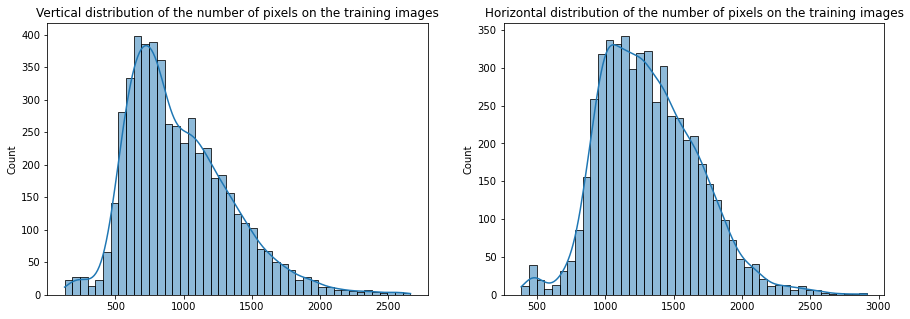

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(x=pixel_h, kde=True)
plt.title('Vertical distribution of the number of pixels on the training images')  
plt.subplot(1, 2, 2)
sns.histplot(x=pixel_l, kde=True)
plt.title('Horizontal distribution of the number of pixels on the training images')
plt.show()

In [10]:
path_test_n = 'chest_xray/test/NORMAL'
df_test = pd.DataFrame()
pixel_h = []
pixel_l = []
for im in img_test_normal:
    image_file = Image.open((os.path.join(path_test_n, im))) # open colour image
    image_file= image_file.convert('L')
    image = np.asarray(image_file)
    pixel_h.append(image.shape[0])
    pixel_l.append(image.shape[1])
    df_row = pd.DataFrame({'image_data':[image],
                             'class':['normal']})
    df_test = pd.concat([df_test, df_row])
    
path_test_p = 'chest_xray/test/PNEUMONIA'
for im in img_test_pathology:
    image_file = Image.open((os.path.join(path_test_p, im))) # open colour image
    image_file= image_file.convert('L')
    image = np.asarray(image_file)
    pixel_h.append(image.shape[0])
    pixel_l.append(image.shape[1])
    df_row = pd.DataFrame({'image_data':[image],
                             'class':['pneumonia']})
    df_test = pd.concat([df_test, df_row])
    
# Присоединим еще и val дататсет состоящий всего лишь из 16 снимков к тестовому:

path_val_n = 'chest_xray/val/NORMAL'
for im in img_val_normal:
    image_file = Image.open((os.path.join(path_val_n, im))) # open colour image
    image_file= image_file.convert('L')
    image = np.asarray(image_file)
    pixel_h.append(image.shape[0])
    pixel_l.append(image.shape[1])
    df_row = pd.DataFrame({'image_data':[image],
                             'class':['normal']})
    df_test = pd.concat([df_test, df_row])
    
path_val_p = 'chest_xray/val/PNEUMONIA'
for im in img_val_pathology:
    image_file = Image.open((os.path.join(path_val_p, im))) # open colour image
    image_file= image_file.convert('L')
    image = np.asarray(image_file)
    pixel_h.append(image.shape[0])
    pixel_l.append(image.shape[1])
    df_row = pd.DataFrame({'image_data':[image],
                             'class':['pneumonia']})
    df_test = pd.concat([df_test, df_row])

In [11]:
df_test

,image_data,class
0,"[[0, 32, 33, 33, 35, 32, 40, 35, 33, 33, 33, 3...",normal
0,"[[0, 1, 1, 0, 42, 39, 38, 39, 33, 32, 33, 35, ...",normal
0,"[[0, 40, 41, 39, 45, 36, 37, 36, 35, 35, 36, 3...",normal
0,"[[2, 64, 77, 71, 75, 74, 77, 71, 75, 72, 73, 7...",normal
0,"[[0, 42, 42, 39, 45, 38, 40, 41, 47, 43, 38, 3...",normal
...,...,...
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",pneumonia
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",pneumonia
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",pneumonia
0,"[[64, 61, 64, 71, 71, 64, 61, 64, 70, 68, 65, ...",pneumonia


Изучим размерности исходных снимков в тестовом датасете:

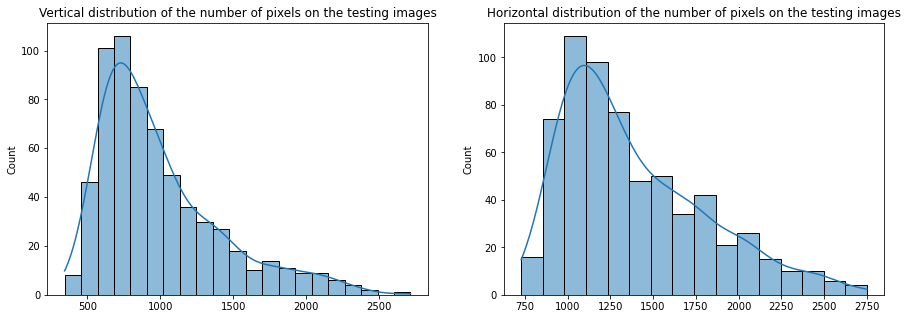

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(x=pixel_h, kde=True)
plt.title('Vertical distribution of the number of pixels on the testing images')  
plt.subplot(1, 2, 2)
sns.histplot(x=pixel_l, kde=True)
plt.title('Horizontal distribution of the number of pixels on the testing images')
plt.show()

Перед тем как разделить на test и validation рандомно перемешаем строки датафрема

In [13]:
df_test = df_test.iloc[np.random.RandomState(seed=42).permutation(len(df_test))]
df_test, df_val = np.array_split(df_test, 2) # Делим пополам

In [14]:
df_test['class'].value_counts()

pneumonia    191
normal       129
Name: class, dtype: int64

In [15]:
df_val['class'].value_counts()

pneumonia    207
normal       113
Name: class, dtype: int64

Сделаем пропорции классов в трейновом датасете равной 50 на 50:

In [16]:
df_train['class'].value_counts()

pneumonia    3875
normal       1341
Name: class, dtype: int64

In [17]:
count_class_1 = len(df_train[df_train['class']=='pneumonia'])
count_class_0 = len(df_train[df_train['class']=='normal'])
dif = count_class_1 - count_class_0

Удалим раномные строки из датафрейма где класс равен pneumonia, чтобы число элементов обоих классов сравнялось

In [18]:
df_train = df_train.reset_index(drop=True)

In [19]:
df_train = df_train.drop(df_train[df_train['class']=='pneumonia'].sample(n=dif,random_state=42).index)

In [20]:
df_train['class'].value_counts()

normal       1341
pneumonia    1341
Name: class, dtype: int64

In [21]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

Загрузим данные в папку data в виде csv файлов:

In [22]:
directory = pwd + '\data'
if not os.path.exists(directory):
    os.makedirs(directory)
df_train.to_csv(directory+'\df_train.csv', sep='\t')
df_test.to_csv(directory+'\df_test.csv', sep='\t')
df_val.to_csv(directory+'\df_val.csv', sep='\t')

Эти загруженные файлы позволят загружать не фотографии, а именно pandas dataframe для тех, кто желает использовать код готовым и не закачивать исходные данные с сайта kaggle. 

Во всех других файлах юпитер ноутбуков, которые будут лежать в этом репозитории на GitHub, как раз будет осуществляться загрузка напрямую из этих csv файлов

Создадим MakeDataset класс, который потом будем импользовать для реализации Dataloader:

In [23]:
class MakeDataset(Dataset):
    def __init__(self, df, transform=None):
        df = df.to_numpy()
        self.x = df[:,0]
        self.y = df[:,2]
        self.n_samples = df.shape[0]
        self.transform = transform
        
    def __getitem__(self, index):
        sample = self.x[index]/225 #привел значения тензоров к дапазону от 0 до 1
        sample = np.float32(sample)
        sample = torch.tensor(np.expand_dims(sample, axis=0)) #добавил канал 1 
        # теперь данные - тензор 1 х H x W
        
        if self.transform is not None:
            sample = self.transform(sample)
        return (sample,  torch.tensor([self.y[index]]))
        
    def __len__(self):
        return self.n_samples

1 - индекс (label) у класса "Наличие пневмонии" <br/>
0 - индекс (label) у класса "Норма"

In [24]:
df_test['label'] = df_test['class'].apply(lambda x: 1.0 if x=='pneumonia' else 0)
df_val['label'] = df_val['class'].apply(lambda x: 1.0 if x=='pneumonia' else 0)
df_train['label'] = df_train['class'].apply(lambda x: 1.0 if x=='pneumonia' else 0)

In [25]:
df_train.head()

,image_data,class,label
0,"[[22, 24, 24, 23, 22, 23, 23, 23, 20, 20, 20, ...",normal,0.0
1,"[[11, 11, 15, 15, 15, 18, 19, 24, 26, 24, 23, ...",normal,0.0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",normal,0.0
3,"[[36, 38, 40, 41, 40, 40, 41, 43, 44, 45, 47, ...",normal,0.0
4,"[[75, 77, 74, 73, 74, 72, 68, 71, 67, 64, 64, ...",normal,0.0


Так как датасет на трейне небольшой, поэтому проведем аугментацию изображений:

In [26]:
from torchvision import transforms, models

Будем осуществлять нормализацию входных данных. Для этого определим величину mean и std по train датасету:

In [27]:
dataset =  MakeDataset(df_train, transform=transforms.Resize((224,224)))
loader = DataLoader(dataset=dataset, batch_size=1, shuffle=False, num_workers=0)

In [28]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    for images, _ in loader:
        batch_samples = images.size(0) 
        images = images.view(batch_samples, images.size(1), -1)
        mean += (images).mean(2).sum(0)
        std += (images).std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    return mean, std

In [29]:
mean_nums, std_nums = get_mean_std(loader)
print('mean =', mean_nums, 'std =', std_nums)

mean = tensor([0.5455]) std = tensor([0.2587])


__Создадим трансформации для датасетов:__<br>
Для тестового будет использоваться лишь однократно трансформация (это будет изменение размера до 224 на 224 и нормализация)
<br><br>
Для train датасета будет использоваться 4 различных трансформации, которые позволят увеличить размер исходного датасета в 4 раза. Будет происходить наращивания (конкатинации) датасетов прошедших три различных трасформации:<br>
1) Изменение угла поворота изображения + сжатие изображения + нормализация <br>
2) Симметричное отображение вокруг вертикали + сжатие изображения + нормализация <br>
3) Изенение параметров яркости, контраста и насыщенности + сжатие изображения + нормализация<br>
4) Сначала будет сжато изображение до размеров 280 на 280 потом рандомно вырежется часть размером 224 на 224, далее с верояностью 0.5 произойдет отражение вокруг горизонтали как в трасформации №2 и потом небольшое рандомное вращение от 0 до 5 градусов + нормализация   

Трансформацию в тензор я не провожу так как данную трансформацию уже реализовал сразу в методе getitem класса MakeDataset

In [30]:
transforms_train_1 = transforms.Compose([transforms.Resize((224,224)),
                                         transforms.RandomRotation(20),
                                         transforms.Normalize(mean = mean_nums, std=std_nums)])

transforms_train_2 = transforms.Compose([transforms.Resize((224,224)),
                                         transforms.RandomHorizontalFlip(p=1),
                                         transforms.Normalize(mean = mean_nums, std=std_nums)])

transforms_train_3 = transforms.Compose([transforms.Resize((224,224)),
                                         transforms.ColorJitter(brightness=0.3,
                                                                contrast=0.1,
                                                                saturation=0.1),
                                         transforms.Normalize(mean = mean_nums, std=std_nums)])

transforms_train_4 = transforms.Compose([transforms.Resize((280,280)),
                                         transforms.RandomCrop(size=(224, 224)),
                                         transforms.RandomHorizontalFlip(p=0.5),
                                         transforms.RandomRotation(5),
                                         transforms.Normalize(mean = mean_nums, std=std_nums)])

# Теперь опишем трасформации для валидационного и тестового датасетов:
                               
transforms_check = transforms.Compose([transforms.Resize((224,224)), 
                                       transforms.Normalize(mean = mean_nums, std=std_nums)]) 

Генрация датасетов:

In [31]:
dataset_test = MakeDataset(df_test, transform=transforms_check)
dataset_val = MakeDataset(df_val, transform=transforms_check)

In [32]:
# Проверка возможности итерироваться по датасету
first = dataset_test[0]
features, labels = first
print(features, labels)

tensor([[[-2.0429, -2.0429, -2.0800,  ..., -2.0401, -2.0401, -2.0401],
         [-2.0828, -2.0828, -2.1001,  ..., -2.0401, -2.0656, -2.0656],
         [-2.1088, -2.1088, -1.9078,  ..., -2.0401, -2.0607, -2.0883],
         ...,
         [-1.9542, -1.9542, -1.9714,  ..., -1.9714, -1.9542, -1.9542],
         [-1.9542, -1.9542, -1.9714,  ..., -1.9714, -1.9542, -1.9542],
         [-1.9542, -1.9542, -1.9714,  ..., -1.9714, -1.9542, -1.9542]]]) tensor([1.])


In [33]:
features.shape

torch.Size([1, 224, 224])

In [34]:
dataset_train_1 = MakeDataset(df_train, transform=transforms_train_1)
dataset_train_2 = MakeDataset(df_train, transform=transforms_train_2)
dataset_train_3 = MakeDataset(df_train, transform=transforms_train_3)
dataset_train_4 = MakeDataset(df_train, transform=transforms_train_4)

Первый вид трансформации:

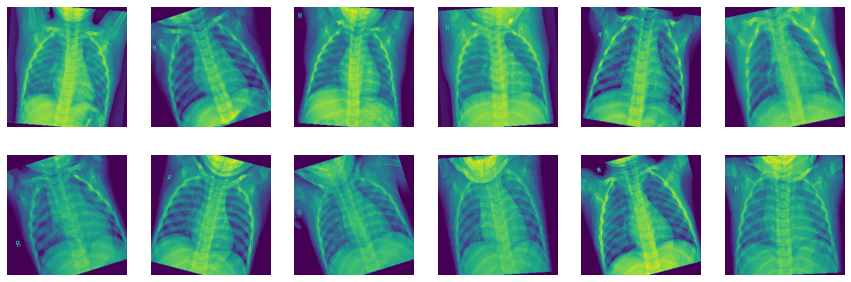

In [35]:
fig, axes = plt.subplots(2, 6, figsize=(15,5))
for i, ax in enumerate(axes.flatten()):
    first = dataset_train_1[i]
    features, labels = first
    image = np.transpose(features,(1,2,0))
    ax.imshow(image)
    ax.axis('off')
plt.show()

Второй вид трансформации:

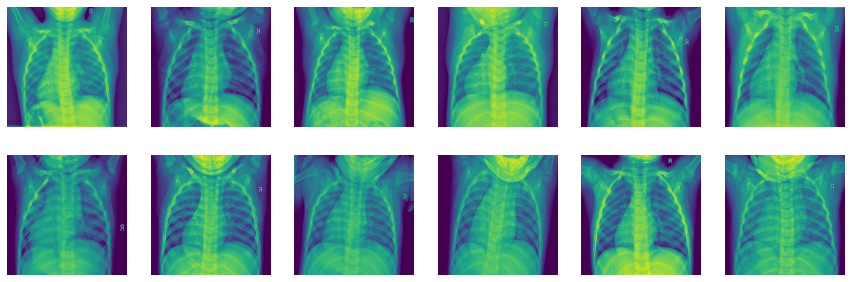

In [36]:
fig, axes = plt.subplots(2, 6, figsize=(15,5))
for i, ax in enumerate(axes.flatten()):
    first = dataset_train_2[i]
    features, labels = first
    image = np.transpose(features,(1,2,0))
    ax.imshow(image)
    ax.axis('off')
plt.show()

Третий вид трансформации:

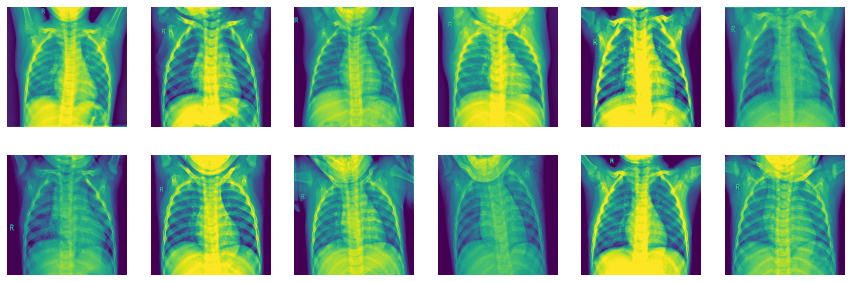

In [37]:
fig, axes = plt.subplots(2, 6, figsize=(15,5))
for i, ax in enumerate(axes.flatten()):
    first = dataset_train_3[i]
    features, labels = first
    image = np.transpose(features,(1,2,0))
    ax.imshow(image)
    ax.axis('off')
plt.show()

Третий вид трансформации:
    

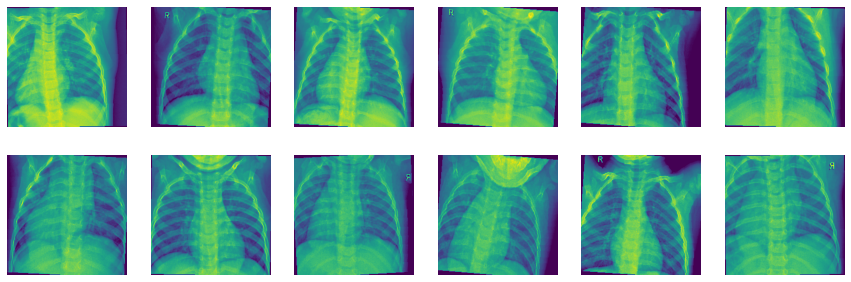

In [38]:
fig, axes = plt.subplots(2, 6, figsize=(15,5))
for i, ax in enumerate(axes.flatten()):
    first = dataset_train_4[i]
    features, labels = first
    image = np.transpose(features,(1,2,0))
    ax.imshow(image)
    ax.axis('off')
plt.show()

In [39]:
print('Число изображений в исходном train датасете =', len(dataset_train_1))

Число изображений в исходном train датасете = 2682


In [40]:
# Сконкатинируем получившиеся датасеты (а именно 2 и 4):
dataset_train = torch.utils.data.ConcatDataset([dataset_train_2,dataset_train_4])

In [41]:
print('Число изображений в получившемся train датасете =', len(dataset_train))

Число изображений в получившемся train датасете = 5364


---

Зададим устройство для вычислений: CPU или GPU

In [42]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [65]:
batch_size = 10 # зададим размер батча

In [66]:
dataloader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)

In [67]:
def imshow(img):
    img = img *std_nums + mean_nums  
    img = img.cpu().numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))  
    plt.show()

Посмотрим как лежат фотки в батчах на тесте:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


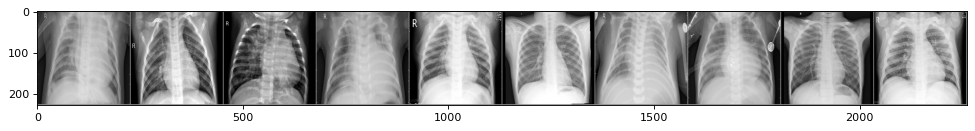

GroundTruth:  pneumonia,  norm,  pneumonia,  pneumonia,  pneumonia,  norm,  pneumonia,  pneumonia,  norm,  pneumonia


In [68]:
classes = ['norm','pneumonia']
image_batch, label_batch = next(iter(dataloader_test))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

plt.figure(figsize=(15, 9), dpi=80)
# выводим изображения в батче
imshow(torchvision.utils.make_grid(image_batch, nrow=10))
print('GroundTruth: ', ',  '.join( classes[int(label_batch[j])] for j in range(batch_size)))

Посмотрим как лежат фотки в батчах на трейне:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


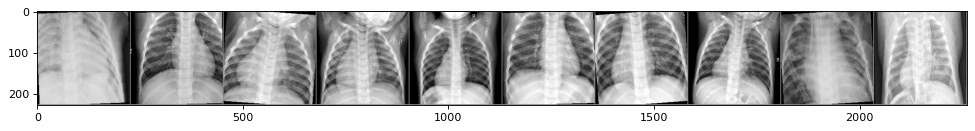

GroundTruth:  pneumonia,  norm,  norm,  norm,  norm,  norm,  norm,  norm,  pneumonia,  pneumonia


In [69]:
dataloader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
classes = ['norm','pneumonia']
image_batch, label_batch = next(iter(dataloader_train))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

plt.figure(figsize=(15, 9), dpi=80)
# выводим изображения в батче
imshow(torchvision.utils.make_grid(image_batch, nrow=10))
print('GroundTruth: ', ',  '.join( classes[int(label_batch[j])] for j in range(batch_size)))

Сохраним получившиеся датасеты:

In [70]:
directory = pwd + '\preprocessed_data'
if not os.path.exists(directory):
    os.makedirs(directory)

Это очень долгая операция, так что ее выполнять надо лишь при первой инициализации или в случае изменения объектов класса pytorch Dataset

In [71]:
#torch.save(dataset_train, directory +'\dataset_train.pth')

In [72]:
#torch.save(dataset_test, directory +'\dataset_test.pth')
#torch.save(dataset_val, directory +'\dataset_val.pth')

### Стадия инициализации и обучения собственной нейронной сетей

In [73]:
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)

print("len(train_dataset) =", len(dataset_train))

val_dataloader= torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=0)

print("len(val_dataset) =", len(dataset_val))

test_dataloader= torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

len(train_dataset) = 5364
len(val_dataset) = 320


In [74]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=3, padding=1)   #224:224
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)       #112:112
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=10, kernel_size=3, padding=1)  #112:112
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=4, stride=4) #28:28
        self.conv3 = torch.nn.Conv2d(
            in_channels=10, out_channels=5, kernel_size=3, padding=1) #28:28
        self.act3 = torch.nn.ReLU()
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2) #14:14


        self.fc1   = torch.nn.Linear(14 * 14 * 5, 50)
        self.act5 = torch.nn.ReLU()

        self.fc2   = torch.nn.Linear(50, 30)
        self.act6 = torch.nn.ReLU()

        self.fc3   = torch.nn.Linear(30, 2)

        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)  
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)

        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
      
        x = self.pool4(x)


          
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act5(x)
        x = self.fc2(x)
        x = self.act6(x)
        x = self.fc3(x)
        
        return x


model = SimpleConvNet().to(device)

In [75]:
print(device)

cpu


In [76]:
import torch.optim as optim
import time 

loss_func = nn.CrossEntropyLoss().to(device)
opt = optim.Adam(model.parameters(), lr=0.005) 

In [77]:
def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

In [78]:
directory = pwd + '\models'
if not os.path.exists(directory):
    os.makedirs(directory)

In [79]:
loss_train = []
acc_train = []
acc_validation = []
loss_validation = []

model.train() 
start_time = time.time()
maxacc = 0
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    running_acc = 0.0
    for batch in tqdm(train_dataloader):
        # получим данные
        image_batch, label_batch  = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        
        # обнуление параметров градиента
        opt.zero_grad()

        # forward + backward + optimize
        y_pred = model(image_batch)
        loss = loss_func(y_pred, label_batch)
        
        loss.backward()
        opt.step()
        
        running_loss += loss.item()   # среднее по батчу так будем искать
        running_acc += accuracy(y_pred, label_batch)
        
    print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader), running_acc / len(train_dataloader)))
    loss_train.append(running_loss / len(train_dataloader))
    acc_train.append(running_acc / len(train_dataloader))

    model.eval()
    acc_val = []
    running_loss_val = 0
    for itr,data in enumerate(val_dataloader):
            imgs = data[0].to(device)
            labels = data[1].to(device)   
            labels = torch.flatten(labels).type(torch.LongTensor)
            y_pred = model(imgs)
            acc_val.append(accuracy(y_pred,labels))
            running_loss_val += loss.item()
    loss_val_ep =  running_loss_val / len(val_dataloader)

    acc_val_ep = np.mean(np.array(acc_val))
    print(f'Validation accuracy - {acc_val_ep}')
    acc_validation.append(acc_val_ep)
    loss_validation.append(loss_val_ep)

    if np.mean(np.array(acc_val)) > maxacc:
            #Saving model because it has higher acc on validation
            maxacc = np.mean(np.array(acc_val)) 
            torch.save(model, directory+'\model_no_TransferLearning.pth')
            
print('Total time {:.4f} seconds'.format(time.time() - start_time))


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [01:46<00:00,  5.05it/s]


[epoch 1] loss: 0.337, acc: 0.858
Validation accuracy - 0.83125


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [01:44<00:00,  5.16it/s]


[epoch 2] loss: 0.232, acc: 0.912
Validation accuracy - 0.85625


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [01:42<00:00,  5.22it/s]


[epoch 3] loss: 0.195, acc: 0.928
Validation accuracy - 0.8031250000000001


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [01:45<00:00,  5.11it/s]


[epoch 4] loss: 0.172, acc: 0.935
Validation accuracy - 0.784375


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [01:48<00:00,  4.94it/s]


[epoch 5] loss: 0.15, acc: 0.945
Validation accuracy - 0.784375


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [01:47<00:00,  5.00it/s]


[epoch 6] loss: 0.141, acc: 0.95
Validation accuracy - 0.828125


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [01:42<00:00,  5.23it/s]


[epoch 7] loss: 0.145, acc: 0.947
Validation accuracy - 0.859375


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [01:41<00:00,  5.28it/s]


[epoch 8] loss: 0.124, acc: 0.955
Validation accuracy - 0.8343750000000001


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [01:41<00:00,  5.30it/s]


[epoch 9] loss: 0.149, acc: 0.944
Validation accuracy - 0.878125


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 537/537 [01:41<00:00,  5.27it/s]


[epoch 10] loss: 0.14, acc: 0.951
Validation accuracy - 0.875
Total time 1078.6334 seconds


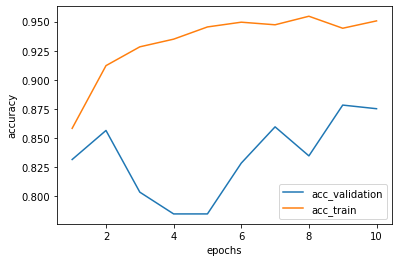

In [81]:
plt.plot([1,2,3,4,5,6,7,8,9,10], acc_validation, label='acc_validation')
plt.plot([1,2,3,4,5,6,7,8,9,10], acc_train, label='acc_train')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')  
plt.show()

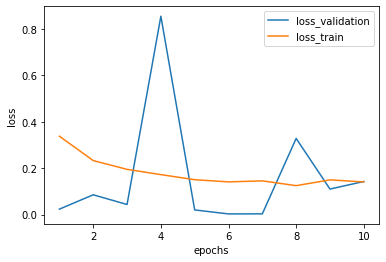

In [82]:
plt.plot([1,2,3,4,5,6,7,8,9,10], loss_validation, label='loss_validation')
plt.plot([1,2,3,4,5,6,7,8,9,10], loss_train, label='loss_train')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')  
plt.show()

In [84]:
wghts = torch.load(directory + '/model_no_TransferLearning.pth')
model.load_state_dict(wghts.state_dict())

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


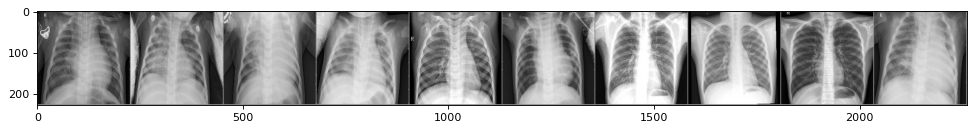

GroundTruth:  pneumonia pneumonia pneumonia pneumonia  norm pneumonia  norm  norm  norm pneumonia
Прогноз:  pneumonia pneumonia pneumonia pneumonia norm pneumonia norm norm norm pneumonia


In [85]:
image_batch, label_batch = next(iter(test_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

plt.figure(figsize=(15, 9), dpi=80)
imshow(torchvision.utils.make_grid(image_batch, nrow=10))
print('GroundTruth: ', ' '.join('%5s' % classes[int(label_batch[j])] for j in range(batch_size)))
outputs = model(image_batch)
predicted = torch.argmax(outputs, dim=1)

print('Прогноз: '," ".join(classes[predicted[j]]for j in range(batch_size)))

In [86]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)

        total += labels.size(0)
        correct += (predicted == label_batch).sum().item()

print(f"Точность модели на test: {100 * correct / total:.2f} %")

Точность модели на test: 89.38 %
